# Alzheimer MRI images data notebook 
by Martin Closter Jespersen from Deloitte Consulting

## About the data 
The data was generated from a real patient cohort of MRI images both with and without alzheimer. The real images are in the dimension of 128x128 and consists of the following distribution (i.e. real distribution):
- 2560 Non alzheimer
- 1792 Very mild alzheimer 
- 717  Mild alzheimer
- 52   Moderate alzheimer

You are provided an evenly distributed synthetic dataset of ~3000 128x128 synthetic MRI images of each class. 

The data was generated using a simple (non state-of-the-art) <b>Conditional Generative Adversial Network (cGAN)</b>. cGANs are generally data hungry and considering this small dataset with great class imbalance, the data quality can be <u><b>limited</b></u>. Though image applications of machine learning has developed far, creating diverse synthetic images is still the main bottleneck. More sophisticated methods have improved this substantially but was not used here due to time and dataset size.

Reading material:
* Analysis of using GANs to replace real biomedical images in classification https://arxiv.org/pdf/1904.08688.pdf
* Synthetic COVID X ray images https://arxiv.org/pdf/2009.12478.pdf
* Synthetizing chest X ray images for model development https://www.researchgate.net/publication/328945795_Synthesizing_Chest_X-Ray_Pathology_for_Training_Deep_Convolutional_Neural_Networks


Investigate how the data can be useful!  

## Possible challenges
- Can you train a model on synthetic data to predict alzheimers on real data (binary = No alzheimer or not)
    - Easiest task of prediction
    - Play with best distribution / synthetic data size needed (most likely a small subsample is sufficient). 
    - Removing redundancy (too similar images) might be needed  (https://github.com/JohannesBuchner/imagehash)
    - Does the performance on real data increase if training only using synthetic data a subset of the alzheimer classes (i.e. leave out less frequent ones)?
- How well does the synthetic data behave on each class on the real data?
    - More complicated task of prediction
- How does a model trained on the real data behave on the synthetic data?
    - This can be useful if one wants to scale a model to new country and want to evaluate if it would succeed
- Do the model trained on real and synthetic data behave similarly? 
    - I.e. do they predict same targets the same classes, or do they use the same part of the images to classify (Grad-CAM or similar method)
- Can you improve the model trained on real data by augmenting it with synthetic data in the training?
- Explore and compare the real and synthetic data
    - Average pixel of each separate class or other create ideas?
- Can you build a model which can predict real from synthetic images, and if so can you understand why it can differentiate?

## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# from tqdm.notebook import tqdm
# from collections import Counter, defaultdict
# from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, random_split

# from torchvision.models import resnet18
# import albumentations as A

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Loading in the images

In [6]:
from utils import load_images

In [7]:
# load images
synth_images, synth_labels = load_images('data/SyntheticDataset', verbose=True)
real_images, real_labels = load_images('data/RealDataset', verbose=True)
real_final_images, real_final_labels = load_images('data/RealTestDataset', verbose=True)

100%|██████████| 1279/1279 [00:03<00:00, 363.65it/s]


In [8]:
# print shapes
print(f'synth_images shape: {synth_images.shape}')
print(f'synth_labels shape: {synth_labels.shape}')
print()
print(f'real_images shape: {real_images.shape}')
print(f'real_labels shape: {real_labels.shape}')
print()
print(f'real_final_images shape: {real_final_images.shape}')
print(f'real_final_labels shape: {real_final_labels.shape}')

synth_images shape: (12000, 128, 128)
synth_labels shape: (12000,)

real_images shape: (5121, 128, 128)
real_labels shape: (5121,)

real_final_images shape: (1279, 128, 128)
real_final_labels shape: (1279,)


In [9]:
# print labels distribution
print(f'synth_labels: {Counter(synth_labels)}')
print(f'real_labels: {Counter(real_labels)}')
print(f'real_final_labels: {Counter(real_final_labels)}')

synth_labels: Counter({0: 3047, 1: 3030, 3: 3023, 2: 2900})
real_labels: Counter({0: 2560, 1: 1792, 2: 717, 3: 52})
real_final_labels: Counter({0: 640, 1: 448, 2: 179, 3: 12})


In [10]:
# binary classification
synth_labels = np.clip(synth_labels, 0, 1)
real_labels = np.clip(real_labels, 0, 1)
real_final_labels = np.clip(real_final_labels, 0, 1)

In [11]:
# print labels distribution after binary classification
print(f'synth_labels: {Counter(synth_labels)}')
print(f'real_labels: {Counter(real_labels)}')
print(f'real_final_labels: {Counter(real_final_labels)}')

synth_labels: Counter({1: 8953, 0: 3047})
real_labels: Counter({1: 2561, 0: 2560})
real_final_labels: Counter({0: 640, 1: 639})


### dataset and dataloader

In [12]:
BATCH_SIZE = 64

In [13]:
# train/test split
synth_train_img, synth_test_img, synth_train_label, synth_test_label = train_test_split(
    synth_images, synth_labels, test_size=0.20, random_state=42,
)
real_train_img, real_test_img, real_train_label, real_test_label = train_test_split(
    real_images, real_labels, test_size=0.20, random_state=42,
)

In [14]:
from torchvision import transforms
from torch.utils.data import DataLoader
from dataset import MRIDataset, Unsqueeze, Repeat

In [15]:
transform = transforms.Compose([
    Unsqueeze(axis=-1),
    Repeat(n_channel=3, axis=-1),
    transforms.ToTensor(),
])

In [50]:
# augs = A.Compose([
#                 #A.ElasticTransform(alpha=0.01,sigma=10, alpha_affine=5, p=0.3),
#                  A.Rotate(limit=5, p=0.3),
#                 A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.3)
#                  ])
#        # A.Compose([A.Blur(blur_limit=3, p=1.0)])
# #        A.Compose([A.Rotate(limit=15, p=0.3)]),
# #        A.Compose([A.GaussNoise(var_limit=(10.0, 500.0), mean=0, p=0.3)])

In [16]:
# make datasets

# synthetic
synth_train_dataset = MRIDataset(
    images=synth_train_img,
    labels=synth_train_label,
    transform=transform,
)
synth_test_dataset = MRIDataset(
    images=synth_test_img,
    labels=synth_test_label,
    transform=transform,
)

# real
real_train_dataset = MRIDataset(
    images=real_train_img,
    labels=real_train_label,
    transform=transform,
)
real_test_dataset = MRIDataset(
    images=real_test_img,
    labels=real_test_label,
    transform=transform,
)

# real_final
real_final_dataset = MRIDataset(
    images=real_final_images,
    labels=real_labels,
    transform=transform,
)

In [17]:
# make dataloaders

# synthetic
synth_train_loader = DataLoader(
    synth_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)
synth_test_loader = DataLoader(
    synth_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

# real
real_train_loader = DataLoader(
    real_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)
real_test_loader = DataLoader(
    real_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

# real_final
real_final_loader = DataLoader(
    real_final_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

### model

In [18]:
N_EPOCHS = 10
LEARNING_RATE = 1e-3

In [19]:
from convnet import ConvDropoutNet, ConvBatchNormNet, make_resnet18, make_pretrained_resnet18
from train import train

### synthetic vs synthetic

In [27]:
model = ConvDropoutNet(in_channels=3, n_classes=2).to(device)

In [28]:
print(f'num of params: {sum(p.numel() for p in model.parameters())}')

num of params: 172434


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [30]:
metrics_train_list = []
metrics_val_list = []

In [31]:
train(
    model=model,
    trainloader=synth_train_loader,
    valloader=synth_test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=N_EPOCHS,
    verbose=True,
)

epoch [1/10]



KeyboardInterrupt: 

In [93]:
%%time
# train / validation loop

for epoch in range(N_EPOCHS):
    
    print(f'epoch [{epoch+1}/{N_EPOCHS}]\n')
    
    # train
    train_metrics = train(
        model, synth_train_loader, criterion, optimizer,
    )
    
    train_accuracy = accuracy_score(
        y_true=np.hstack(train_metrics['ground_truth']),
        y_pred=np.hstack(train_metrics['prediction']),
    )
    print(f'train accuracy: {train_accuracy:.4f}\n')
    
    print('train metrics')
    print(
        classification_report(
            y_true=np.hstack(train_metrics['ground_truth']),
            y_pred=np.hstack(train_metrics['prediction']),
        ),
    )
    print()
    metrics_train_list.append(train_metrics)

    # validate
    val_metrics = validate(
        model, synth_test_loader, criterion,
    )
    
    val_accuracy = accuracy_score(
        y_true=np.hstack(val_metrics['ground_truth']),
        y_pred=np.hstack(val_metrics['prediction']),
    )

    print(f'val accuracy: {val_accuracy:.4f}\n')
    
    print('val metrics')
    print(
        classification_report(
            y_true=np.hstack(val_metrics['ground_truth']),
            y_pred=np.hstack(val_metrics['prediction']),
        ),
    )
    print()
    metrics_val_list.append(val_metrics)
    print('='*53)

epoch [1/10]

train accuracy: 0.7542

train metrics
              precision    recall  f1-score   support

           0       0.53      0.11      0.18      2391
           1       0.77      0.97      0.86      7209

    accuracy                           0.75      9600
   macro avg       0.65      0.54      0.52      9600
weighted avg       0.71      0.75      0.69      9600


val accuracy: 0.8325

val metrics
              precision    recall  f1-score   support

           0       0.67      0.77      0.71       656
           1       0.91      0.86      0.88      1744

    accuracy                           0.83      2400
   macro avg       0.79      0.81      0.80      2400
weighted avg       0.84      0.83      0.84      2400


epoch [2/10]

train accuracy: 0.8541

train metrics
              precision    recall  f1-score   support

           0       0.74      0.63      0.68      2391
           1       0.88      0.93      0.91      7209

    accuracy                           0.8

In [94]:
[accuracy_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.7541666666666667,
 0.8540625,
 0.8845833333333334,
 0.91625,
 0.9445833333333333,
 0.9609375,
 0.9557291666666666,
 0.9772916666666667,
 0.98375,
 0.9832291666666667]

In [95]:
[precision_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.7665164339892272,
 0.8842286319132046,
 0.9013287725299303,
 0.9327117957032833,
 0.957642220699109,
 0.9707908514742353,
 0.9665749656121045,
 0.9836723398367234,
 0.9879618098796181,
 0.988359201773836]

In [96]:
[recall_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.9672631432931058,
 0.9270356498820919,
 0.9503398529615759,
 0.9575530586766542,
 0.9690664447218754,
 0.9773893743931197,
 0.9747537799972257,
 0.9861284505479262,
 0.9904286308780691,
 0.9893189069219032]

In [97]:
np.std([accuracy_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list])

0.05614799392874355

In [98]:
[precision_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.9076549210206561,
 0.8338966682761951,
 0.94049008168028,
 0.9821757836508912,
 0.886676875957121,
 0.9884858952216465,
 0.9917452830188679,
 0.9897260273972602,
 0.9863481228668942,
 0.992]

In [99]:
[recall_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.856651376146789,
 0.9902522935779816,
 0.9243119266055045,
 0.9162844036697247,
 0.9959862385321101,
 0.9845183486238532,
 0.9644495412844036,
 0.9942660550458715,
 0.9942660550458715,
 0.9954128440366973]

In [100]:
import shap

In [101]:
synth_train_dataset.images.shape

(9600, 128, 128)

tensor([-6.8837], device='cuda:5', grad_fn=<SqueezeBackward1>)
Real label : 0.0     Predicted label : 0.0


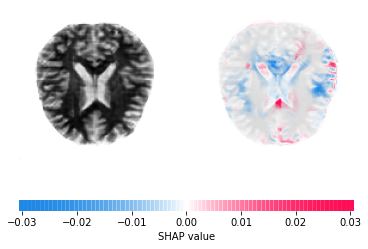

In [73]:
background = torch.tensor(synth_test_dataset.images[:100],dtype=torch.float,device=device).unsqueeze(1)
test_images = torch.tensor([synth_test_dataset.images[-1]],dtype=torch.float,device=device).unsqueeze(1)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
print(model(test_images).squeeze(-1))
if model(test_images).squeeze(-1) > 0:
    prediction = 1.0
else:
    prediction = 0.0
print(f'Real label : {synth_test_dataset.labels[-1]}     Predicted label : {prediction}')
shap.image_plot(shap_numpy, -test_numpy,)

In [47]:
model(test_images).squeeze(-1)

tensor([2.5257], device='cuda:5', grad_fn=<SqueezeBackward1>)

tensor([9.1161], device='cuda:5', grad_fn=<SqueezeBackward1>)
Real label : 1.0     Predicted label : 1.0


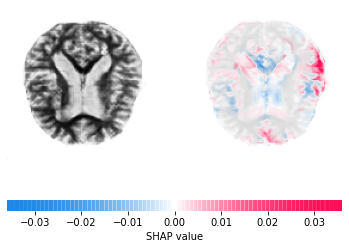

In [77]:
background = torch.tensor(synth_test_dataset.images[:100],dtype=torch.float,device=device).unsqueeze(1)
test_images = torch.tensor([synth_test_dataset.images[-7]],dtype=torch.float,device=device).unsqueeze(1)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
print(model(test_images).squeeze(-1))
if model(test_images).squeeze(-1) > 0:
    prediction = 1.0
else:
    prediction = 0.0
print(f'Real label : {synth_test_dataset.labels[-7]}     Predicted label : {prediction}')
shap.image_plot(shap_numpy, -test_numpy,)

tensor([-1.0856], device='cuda:5', grad_fn=<SqueezeBackward1>)
Real label : 0.0     Predicted label : 0.0


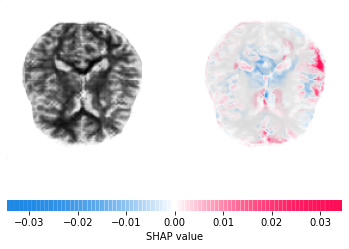

In [76]:
background = torch.tensor(synth_test_dataset.images[:100],dtype=torch.float,device=device).unsqueeze(1)
test_images = torch.tensor([synth_test_dataset.images[-3]],dtype=torch.float,device=device).unsqueeze(1)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
print(model(test_images).squeeze(-1))
if model(test_images).squeeze(-1) > 0:
    prediction = 1.0
else:
    prediction = 0.0
print(f'Real label : {synth_test_dataset.labels[-3]}     Predicted label : {prediction}')
shap.image_plot(shap_numpy, -test_numpy,)

tensor([4.7306], device='cuda:5', grad_fn=<SqueezeBackward1>)
Real label : 1.0     Predicted label : 1.0


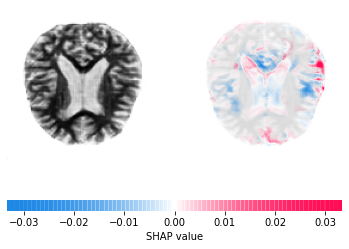

In [81]:
background = torch.tensor(synth_test_dataset.images[:100],dtype=torch.float,device=device).unsqueeze(1)
test_images = torch.tensor([synth_test_dataset.images[-12]],dtype=torch.float,device=device).unsqueeze(1)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
print(model(test_images).squeeze(-1))
if model(test_images).squeeze(-1) > 0:
    prediction = 1.0
else:
    prediction = 0.0
print(f'Real label : {synth_test_dataset.labels[-12]}     Predicted label : {prediction}')
shap.image_plot(shap_numpy, -test_numpy,)

### real vs real

In [102]:
# model = torch.hub.load('pytorch/vision:v0.4.0', 'resnet18', pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
# model = model.to(device)

In [103]:
# model = LeNet().to(device)
model = resnet18(num_classes=1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [104]:
sum(p.numel() for p in model.parameters())

11170753

In [105]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# optimizer = optim.Adam([
#     {'params': (p[1] for p in model.named_parameters() if p[0] not in {'fc.weight', 'fc.bias'}), 'lr': 1e-4},
#     {'params': model.fc.parameters(), 'lr': 1e-3},
# ])

In [106]:
metrics_train_list = []
metrics_val_list = []

In [107]:
# train / validation loop
for epoch in range(N_EPOCHS):
    
    print(f'epoch [{epoch+1}/{N_EPOCHS}]\n')
    
    # train
    train_metrics = train(
        model, real_train_loader, criterion, optimizer,
    )
    
    train_accuracy = accuracy_score(
        y_true=np.hstack(train_metrics['ground_truth']),
        y_pred=np.hstack(train_metrics['prediction']),
    )
    print(f'train accuracy: {train_accuracy:.4f}\n')
    
    print('train metrics')
    print(
        classification_report(
            y_true=np.hstack(train_metrics['ground_truth']),
            y_pred=np.hstack(train_metrics['prediction']),
        ),
    )
    print()
    metrics_train_list.append(train_metrics)

    # validate
    val_metrics = validate(
        model, real_test_loader, criterion,
    )
    
    val_accuracy = accuracy_score(
        y_true=np.hstack(val_metrics['ground_truth']),
        y_pred=np.hstack(val_metrics['prediction']),
    )

    print(f'val accuracy: {val_accuracy:.4f}\n')
    
    print('val metrics')
    print(
        classification_report(
            y_true=np.hstack(val_metrics['ground_truth']),
            y_pred=np.hstack(val_metrics['prediction']),
        ),
    )
    print()
    metrics_val_list.append(val_metrics)
    print('='*53)

epoch [1/10]

train accuracy: 0.7666

train metrics
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2049
           1       0.76      0.78      0.77      2047

    accuracy                           0.77      4096
   macro avg       0.77      0.77      0.77      4096
weighted avg       0.77      0.77      0.77      4096


val accuracy: 0.7278

val metrics
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       511
           1       0.94      0.49      0.64       514

    accuracy                           0.73      1025
   macro avg       0.80      0.73      0.71      1025
weighted avg       0.80      0.73      0.71      1025


epoch [2/10]

train accuracy: 0.8931

train metrics
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2049
           1       0.89      0.89      0.89      2047

    accuracy                           0.8

In [108]:
[accuracy_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.7666015625,
 0.89306640625,
 0.94140625,
 0.95361328125,
 0.96875,
 0.976806640625,
 0.984375,
 0.994140625,
 0.9873046875,
 0.97314453125]

In [109]:
[precision_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.7608799617407939,
 0.8937836514929026,
 0.9448547513540128,
 0.9509470616804274,
 0.969652471855115,
 0.9751703992210321,
 0.9857912787849094,
 0.9931740614334471,
 0.986822840409956,
 0.9745222929936306]

In [110]:
[recall_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.7772349780166097,
 0.8920371275036639,
 0.9374694675134343,
 0.9565217391304348,
 0.9677576941866145,
 0.978505129457743,
 0.9829018075232047,
 0.995114802149487,
 0.9877870053737177,
 0.9716658524670249]

In [111]:
[accuracy_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.7278048780487805,
 0.615609756097561,
 0.7521951219512195,
 0.9424390243902439,
 0.9248780487804878,
 0.6907317073170731,
 0.8936585365853659,
 0.9502439024390243,
 0.9297560975609757,
 0.7795121951219512]

In [112]:
[precision_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.9368029739776952,
 1.0,
 0.6692708333333334,
 0.952286282306163,
 0.9866369710467706,
 1.0,
 0.827140549273021,
 0.9126559714795008,
 0.8960573476702509,
 0.6945945945945946]

In [113]:
[recall_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.490272373540856,
 0.23346303501945526,
 1.0,
 0.9319066147859922,
 0.8618677042801557,
 0.3832684824902724,
 0.9961089494163424,
 0.9961089494163424,
 0.9727626459143969,
 1.0]

tensor([5.3732], device='cuda:5', grad_fn=<SqueezeBackward1>)
Real label : 1.0     Predicted label : 1.0


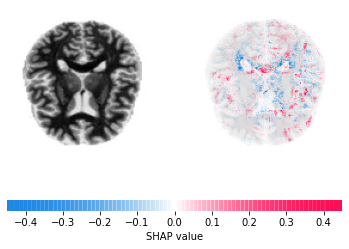

In [64]:
background = torch.tensor(real_test_dataset.images[:100],dtype=torch.float,device=device).unsqueeze(1)
test_images = torch.tensor([real_test_dataset.images[-1]],dtype=torch.float,device=device).unsqueeze(1)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
print(model(test_images).squeeze(-1))
if model(test_images).squeeze(-1) > 0:
    prediction = 1.0
else:
    prediction = 0.0
print(f'Real label : {real_test_dataset.labels[-1]}     Predicted label : {prediction}')
shap.image_plot(shap_numpy, -test_numpy,)

tensor([-5.5069], device='cuda:5', grad_fn=<SqueezeBackward1>)
Real label : 0.0     Predicted label : 0.0


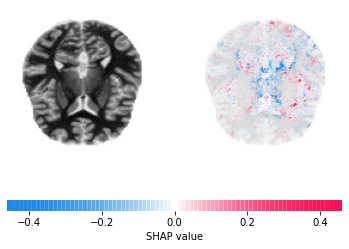

In [65]:
background = torch.tensor(real_test_dataset.images[:100],dtype=torch.float,device=device).unsqueeze(1)
test_images = torch.tensor([real_test_dataset.images[-5]],dtype=torch.float,device=device).unsqueeze(1)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
print(model(test_images).squeeze(-1))
if model(test_images).squeeze(-1) > 0:
    prediction = 1.0
else:
    prediction = 0.0
print(f'Real label : {real_test_dataset.labels[-5]}     Predicted label : {prediction}')
shap.image_plot(shap_numpy, -test_numpy,)

tensor([-2.9895], device='cuda:5', grad_fn=<SqueezeBackward1>)
Real label : 0.0     Predicted label : 0.0


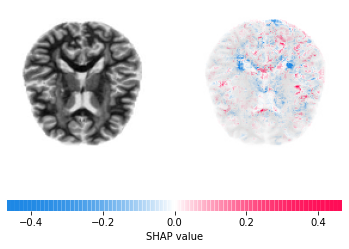

In [66]:
background = torch.tensor(real_test_dataset.images[:100],dtype=torch.float,device=device).unsqueeze(1)
test_images = torch.tensor([real_test_dataset.images[-3]],dtype=torch.float,device=device).unsqueeze(1)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
print(model(test_images).squeeze(-1))
if model(test_images).squeeze(-1) > 0:
    prediction = 1.0
else:
    prediction = 0.0
print(f'Real label : {real_test_dataset.labels[-3]}     Predicted label : {prediction}')
shap.image_plot(shap_numpy, -test_numpy,)

tensor([6.1707], device='cuda:5', grad_fn=<SqueezeBackward1>)
Real label : 1.0     Predicted label : 1.0


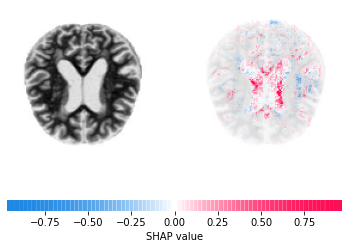

In [67]:
background = torch.tensor(real_test_dataset.images[:100],dtype=torch.float,device=device).unsqueeze(1)
test_images = torch.tensor([real_test_dataset.images[-7]],dtype=torch.float,device=device).unsqueeze(1)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
print(model(test_images).squeeze(-1))
if model(test_images).squeeze(-1) > 0:
    prediction = 1.0
else:
    prediction = 0.0
print(f'Real label : {real_test_dataset.labels[-7]}     Predicted label : {prediction}')
shap.image_plot(shap_numpy, -test_numpy,)

### synthetic vs real

In [40]:
# model = torch.hub.load('pytorch/vision:v0.4.0', 'resnet18', pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
# model = model.to(device)

In [41]:
# model = LeNet().to(device)
model = resnet18(num_classes=1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [42]:
sum(p.numel() for p in model.parameters())

11170753

In [43]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# optimizer = optim.Adam([
#     {'params': (p[1] for p in model.named_parameters() if p[0] not in {'fc.weight', 'fc.bias'}), 'lr': 1e-4},
#     {'params': model.fc.parameters(), 'lr': 1e-3},
# ])

In [44]:
metrics_train_list = []
metrics_val_list = []

In [46]:
# train / validation loop
for epoch in range(10):
    
    print(f'epoch [{epoch+1}/{N_EPOCHS}]\n')
    
    # train
    train_metrics = train(
        model, synth_train_loader, criterion, optimizer,
    )
    
    train_accuracy = accuracy_score(
        y_true=np.hstack(train_metrics['ground_truth']),
        y_pred=np.hstack(train_metrics['prediction']),
    )
    print(f'train accuracy: {train_accuracy:.4f}\n')
    
    print('train metrics')
    print(
        classification_report(
            y_true=np.hstack(train_metrics['ground_truth']),
            y_pred=np.hstack(train_metrics['prediction']),
        ),
    )
    print()
    metrics_train_list.append(train_metrics)

    # validate
    val_metrics = validate(
        model,real_train_loader, criterion,
    )
    
    val_accuracy = accuracy_score(
        y_true=np.hstack(val_metrics['ground_truth']),
        y_pred=np.hstack(val_metrics['prediction']),
    )

    print(f'val accuracy: {val_accuracy:.4f}\n')
    
    print('val metrics')
    print(
        classification_report(
            y_true=np.hstack(val_metrics['ground_truth']),
            y_pred=np.hstack(val_metrics['prediction']),
        ),
    )
    print()
    metrics_val_list.append(val_metrics)
    print('='*53)
    
    torch.save(model.state_dict(), f'model_{epoch}.pth')

epoch [1/10]

train accuracy: 0.9956

train metrics
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2391
           1       1.00      1.00      1.00      7209

    accuracy                           1.00      9600
   macro avg       0.99      0.99      0.99      9600
weighted avg       1.00      1.00      1.00      9600


val accuracy: 0.6143

val metrics
              precision    recall  f1-score   support

           0       0.59      0.78      0.67      2049
           1       0.67      0.44      0.54      2047

    accuracy                           0.61      4096
   macro avg       0.63      0.61      0.60      4096
weighted avg       0.63      0.61      0.60      4096


epoch [2/10]

train accuracy: 0.9968

train metrics
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2391
           1       1.00      1.00      1.00      7209

    accuracy                           1.0

In [47]:
# final validation
final_metrics = validate(
    model, real_final_loader, criterion,
)

final_accuracy = accuracy_score(
    y_true=np.hstack(final_metrics['ground_truth']),
    y_pred=np.hstack(final_metrics['prediction']),
)

print(f'final accuracy: {final_accuracy:.4f}\n')

print('final metrics')
print(
    classification_report(
        y_true=np.hstack(final_metrics['ground_truth']),
        y_pred=np.hstack(final_metrics['prediction']),
    ),
)

final accuracy: 0.4973

final metrics
              precision    recall  f1-score   support

           0       0.52      0.18      0.27       653
           1       0.49      0.83      0.62       626

    accuracy                           0.50      1279
   macro avg       0.51      0.50      0.44      1279
weighted avg       0.51      0.50      0.44      1279



In [48]:
[accuracy_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.9614583333333333,
 0.9907291666666667,
 0.9890625,
 0.9946875,
 0.9952083333333334,
 0.99625,
 0.995,
 0.994375,
 0.9939583333333334,
 0.9969791666666666,
 0.995625,
 0.9967708333333334,
 0.998125,
 0.9980208333333334,
 0.9941666666666666,
 0.9965625,
 0.9977083333333333,
 0.99875,
 0.9984375,
 0.9988541666666667]

In [49]:
[precision_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.9715901254999311,
 0.9922566371681416,
 0.9929225645295587,
 0.9958437240232751,
 0.9962588333102397,
 0.9970893970893971,
 0.9962577962577963,
 0.9963923962813931,
 0.9955647955647956,
 0.9977814753189129,
 0.9976392167754479,
 0.9977808599167822,
 0.9987515605493134,
 0.9987513873473918,
 0.9961159661534194,
 0.9973662323260327,
 0.9986124601082281,
 0.9991677070328756,
 0.9987520798668885,
 0.9991678224687933]

In [50]:
[recall_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.977250658898599,
 0.9954223886808157,
 0.9925093632958801,
 0.9970869746150645,
 0.997364405604106,
 0.997919267582189,
 0.9970869746150645,
 0.9961159661534194,
 0.9963933971424608,
 0.9981966985712304,
 0.9965321126369816,
 0.997919267582189,
 0.9987515605493134,
 0.9986128450547926,
 0.9961159661534194,
 0.9980579830767097,
 0.9983354140657511,
 0.9991677070328756,
 0.9991677070328756,
 0.9993064225273963]

In [51]:
[accuracy_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.5113369820172009,
 0.472243940578577,
 0.5191555903049258,
 0.48553557466770914,
 0.49569976544175137,
 0.48553557466770914,
 0.4988272087568413,
 0.506645817044566,
 0.490226739640344,
 0.4980453479280688,
 0.6142578125,
 0.630615234375,
 0.645751953125,
 0.618408203125,
 0.573486328125,
 0.618896484375,
 0.606689453125,
 0.619140625,
 0.64794921875,
 0.62060546875]

In [52]:
[precision_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.5047619047619047,
 0.4775846294602013,
 0.5143603133159269,
 0.4850467289719626,
 0.48998946259220233,
 0.4846153846153846,
 0.49070631970260226,
 0.4940898345153664,
 0.487279843444227,
 0.49236641221374045,
 0.6728349370836417,
 0.6656327543424317,
 0.6742690058479532,
 0.6666666666666666,
 0.6968503937007874,
 0.6650815217391305,
 0.6807628524046434,
 0.6650847457627118,
 0.6566545831175556,
 0.6727400140154169]

In [53]:
[recall_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.08466453674121406,
 0.8338658146964856,
 0.3146964856230032,
 0.829073482428115,
 0.7428115015974441,
 0.805111821086262,
 0.6325878594249201,
 0.33386581469648563,
 0.7955271565495208,
 0.8242811501597445,
 0.4440644846116268,
 0.524181729360039,
 0.5632633121641426,
 0.47288715192965314,
 0.25940400586223744,
 0.4782608695652174,
 0.40107474352711286,
 0.47923790913532,
 0.6194430874450415,
 0.4689789936492428]

### adversarial validation

In [54]:
all_images = np.concatenate([synth_images, real_images])
all_labels = np.concatenate([np.zeros(len(synth_images)), np.ones(len(real_images))])

In [55]:
all_images.shape, all_labels.shape

((17121, 128, 128), (17121,))

In [56]:
all_labels = all_labels.astype(np.float32)

In [57]:
adv_val_dataset = MRIDataset(all_images, all_labels, do_rgb_channels=False)

In [58]:
adv_val_train_dataset, adv_val_test_dataset = random_split(
    adv_val_dataset, [int(len(adv_val_dataset) * 0.8), len(adv_val_dataset) - int(len(adv_val_dataset) * 0.8)],
)

In [59]:
adv_val_train_loader = DataLoader(
    adv_val_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)
adv_val_test_loader = DataLoader(
    adv_val_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

In [60]:
# model = torch.hub.load('pytorch/vision:v0.4.0', 'resnet18', pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
# model = model.to(device)

In [61]:
model = LeNet(p=0).to(device)
# model = resnet18(num_classes=1)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model = model.to(device)

In [62]:
sum(p.numel() for p in model.parameters())

170049

In [63]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [64]:
metrics_train_list = []
metrics_val_list = []

In [65]:
# train / validation loop
for epoch in range(N_EPOCHS):
    
    print(f'epoch [{epoch+1}/{N_EPOCHS}]\n')
    
    # train
    train_metrics = train(
        model, adv_val_train_loader, criterion, optimizer,
    )
    
    train_accuracy = accuracy_score(
        y_true=np.hstack(train_metrics['ground_truth']),
        y_pred=np.hstack(train_metrics['prediction']),
    )
    print(f'train accuracy: {train_accuracy:.4f}\n')
    
    print('train metrics')
    print(
        classification_report(
            y_true=np.hstack(train_metrics['ground_truth']),
            y_pred=np.hstack(train_metrics['prediction']),
        ),
    )
    print()
    metrics_train_list.append(train_metrics)

    # validate
    val_metrics = validate(
        model, adv_val_test_loader, criterion,
    )
    
    val_accuracy = accuracy_score(
        y_true=np.hstack(val_metrics['ground_truth']),
        y_pred=np.hstack(val_metrics['prediction']),
    )

    print(f'val accuracy: {val_accuracy:.4f}\n')
    
    print('val metrics')
    print(
        classification_report(
            y_true=np.hstack(val_metrics['ground_truth']),
            y_pred=np.hstack(val_metrics['prediction']),
        ),
    )
    print()
    metrics_val_list.append(val_metrics)
    print('='*53)

epoch [1/10]

train accuracy: 0.6955

train metrics
              precision    recall  f1-score   support

           0       0.70      0.98      0.82      9629
           1       0.23      0.01      0.02      4067

    accuracy                           0.70     13696
   macro avg       0.47      0.50      0.42     13696
weighted avg       0.56      0.70      0.58     13696


val accuracy: 0.6923

val metrics
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      2371
           1       0.00      0.00      0.00      1054

    accuracy                           0.69      3425
   macro avg       0.35      0.50      0.41      3425
weighted avg       0.48      0.69      0.57      3425


epoch [2/10]

train accuracy: 0.8445

train metrics
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      9629
           1       0.90      0.54      0.67      4067

    accuracy                           0.8

In [66]:
[accuracy_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.6954585280373832,
 0.8444801401869159,
 0.9878066588785047,
 0.9976635514018691,
 0.9990508177570093,
 0.9997809579439252,
 0.9967143691588785,
 0.9997809579439252,
 1.0,
 0.997517523364486]

In [67]:
[precision_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.22916666666666666,
 0.897741273100616,
 0.987256371814093,
 0.9975339087546239,
 0.9995071463775259,
 0.999754058042302,
 0.9960532807104094,
 0.999754058042302,
 1.0,
 0.9967972406996797]

In [68]:
[recall_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_train_list]

[0.010818785345463487,
 0.537496926481436,
 0.9714777477255963,
 0.9945906073272682,
 0.9972953036636342,
 0.9995082370297517,
 0.9928694369313991,
 0.9995082370297517,
 1.0,
 0.9948364888123924]

In [69]:
[accuracy_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.6922627737226278,
 0.9783941605839416,
 0.9976642335766424,
 0.9991240875912408,
 0.9997080291970802,
 0.9997080291970802,
 0.9997080291970802,
 0.9991240875912408,
 0.9997080291970802,
 0.9997080291970802]

In [70]:
[precision_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

/app/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.0,
 0.9890219560878244,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9990521327014218]

In [71]:
[recall_score(
        y_true=np.hstack(i['ground_truth']),
        y_pred=np.hstack(i['prediction']),
    )
 for i in metrics_val_list]

[0.0,
 0.9402277039848197,
 0.9924098671726755,
 0.9971537001897534,
 0.9990512333965844,
 0.9990512333965844,
 0.9990512333965844,
 0.9971537001897534,
 0.9990512333965844,
 1.0]

### top_k

In [72]:
synth_dataset = MRIDataset(synth_images, synth_labels, do_rgb_channels=False)
real_dataset = MRIDataset(real_images, real_labels, do_rgb_channels=False)

In [73]:
synth_loader = DataLoader(
    synth_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)
real_loader = DataLoader(
    real_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

In [74]:
scores = []
for img, _ in tqdm(synth_dataset):
    with torch.no_grad():
        score = model(img.unsqueeze(0)).item()
    scores.append(score)

In [75]:
np.min(scores), np.max(scores)

(-19.14722442626953, 1.1734240055084229)

In [76]:
indices = np.argsort(scores)[-6000:]

good_synth_images = synth_images[indices]
good_synth_labels = synth_labels[indices]

In [77]:
Counter(good_synth_labels)

Counter({1.0: 3900, 0.0: 2100})

In [78]:
good_synth_dataset = MRIDataset(good_synth_images, good_synth_labels, do_rgb_channels=False)

In [79]:
good_synth_loader = DataLoader(
    good_synth_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

### synthetic vs real 2.0

In [80]:
# model = torch.hub.load('pytorch/vision:v0.4.0', 'resnet18', pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
# model = model.to(device)

In [81]:
# model = LeNet().to(device)
model = resnet18(num_classes=1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [82]:
sum(p.numel() for p in model.parameters())

11170753

In [83]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [84]:
# train / validation loop
for epoch in range(10):
    
    print(f'epoch [{epoch+1}/{N_EPOCHS}]\n')
    
    # train
    train_metrics = train(
        model, good_synth_loader, criterion, optimizer,
    )
    
    train_accuracy = accuracy_score(
        y_true=np.hstack(train_metrics['ground_truth']),
        y_pred=np.hstack(train_metrics['prediction']),
    )
    print(f'train accuracy: {train_accuracy:.4f}\n')
    
    print('train metrics')
    print(
        classification_report(
            y_true=np.hstack(train_metrics['ground_truth']),
            y_pred=np.hstack(train_metrics['prediction']),
        ),
    )
    print()

    # validate
    val_metrics = validate(
        model, real_loader, criterion,
    )
    
    val_accuracy = accuracy_score(
        y_true=np.hstack(val_metrics['ground_truth']),
        y_pred=np.hstack(val_metrics['prediction']),
    )

    print(f'val accuracy: {val_accuracy:.4f}\n')
    
    print('val metrics')
    print(
        classification_report(
            y_true=np.hstack(val_metrics['ground_truth']),
            y_pred=np.hstack(val_metrics['prediction']),
        ),
    )
    print()
    print('='*53)
    
    torch.save(model.state_dict(), f'model_{epoch}.pth')

epoch [1/10]

train accuracy: 0.9402

train metrics
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2100
           1       0.95      0.96      0.95      3900

    accuracy                           0.94      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.94      0.94      0.94      6000


val accuracy: 0.5204

val metrics
              precision    recall  f1-score   support

           0       0.51      0.95      0.66      2560
           1       0.64      0.09      0.16      2561

    accuracy                           0.52      5121
   macro avg       0.58      0.52      0.41      5121
weighted avg       0.58      0.52      0.41      5121


epoch [2/10]

train accuracy: 0.9827

train metrics
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2100
           1       0.98      0.99      0.99      3900

    accuracy                           0.9

In [85]:
# final validation
final_metrics = validate(
    model, real_final_loader, criterion,
)

final_accuracy = accuracy_score(
    y_true=np.hstack(final_metrics['ground_truth']),
    y_pred=np.hstack(final_metrics['prediction']),
)

print(f'final accuracy: {final_accuracy:.4f}\n')

print('final metrics')
print(
    classification_report(
        y_true=np.hstack(final_metrics['ground_truth']),
        y_pred=np.hstack(final_metrics['prediction']),
    ),
)

final accuracy: 0.4855

final metrics
              precision    recall  f1-score   support

           0       0.48      0.11      0.17       653
           1       0.49      0.88      0.63       626

    accuracy                           0.49      1279
   macro avg       0.48      0.49      0.40      1279
weighted avg       0.48      0.49      0.40      1279



In [300]:
# final validation
final_metrics = validate(
    model, real_final_loader, criterion,
)

final_accuracy = accuracy_score(
    y_true=np.hstack(final_metrics['ground_truth']),
    y_pred=np.hstack(final_metrics['prediction']),
)

print(f'final accuracy: {final_accuracy:.4f}\n')

print('final metrics')
print(
    classification_report(
        y_true=np.hstack(final_metrics['ground_truth']),
        y_pred=np.hstack(final_metrics['prediction']),
    ),
)

final accuracy: 0.5051

final metrics
              precision    recall  f1-score   support

           0       0.52      0.39      0.45       653
           1       0.50      0.62      0.55       626

    accuracy                           0.51      1279
   macro avg       0.51      0.51      0.50      1279
weighted avg       0.51      0.51      0.50      1279



In [183]:
import albumentations as A

In [102]:
# plt.imshow(synth_dataset[1403][0].cpu().numpy()[0], cmap='gray')

In [ ]:
1/0

### visualize maximum stimuli

In [88]:
def plot_img(img):
    plt.imshow(img.detach().cpu().numpy()[0][0] * 255, cmap='gray')

In [89]:
inputs = torch.randn(1, 3, 128, 128, requires_grad=True).to(device)
inputs.retain_grad()
labels = torch.tensor([0], dtype=torch.float, device=device)

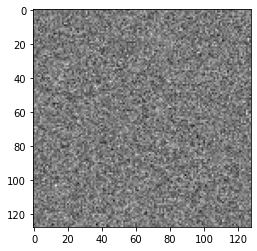

In [90]:
plot_img(inputs)

In [91]:
criterion = nn.BCEWithLogitsLoss()

In [92]:
for param in model.parameters():
    param.requires_grad = False

In [97]:
for _ in range(1000):
    outputs = model(inputs).squeeze(-1)
    loss = criterion(outputs, labels)
    loss.backward()
    print(loss.item())
    inputs.data += inputs.grad.data
    print(torch.norm(inputs.grad))
    inputs.grad.zero_()

14.20914077758789
tensor(0.0339, device='cuda:0')
14.209914207458496
tensor(0.0318, device='cuda:0')
14.210760116577148
tensor(0.0329, device='cuda:0')
14.211531639099121
tensor(0.0323, device='cuda:0')
14.212376594543457
tensor(0.0329, device='cuda:0')
14.213138580322266
tensor(0.0321, device='cuda:0')
14.213958740234375
tensor(0.0318, device='cuda:0')
14.214767456054688
tensor(0.0325, device='cuda:0')
14.215554237365723
tensor(0.0323, device='cuda:0')
14.216348648071289
tensor(0.0326, device='cuda:0')
14.217109680175781
tensor(0.0311, device='cuda:0')
14.217894554138184
tensor(0.0322, device='cuda:0')
14.218671798706055
tensor(0.0315, device='cuda:0')
14.219460487365723
tensor(0.0305, device='cuda:0')
14.220236778259277
tensor(0.0320, device='cuda:0')
14.220958709716797
tensor(0.0334, device='cuda:0')
14.221713066101074
tensor(0.0318, device='cuda:0')
14.222501754760742
tensor(0.0310, device='cuda:0')
14.223274230957031
tensor(0.0308, device='cuda:0')
14.224032402038574
tensor(0.0327

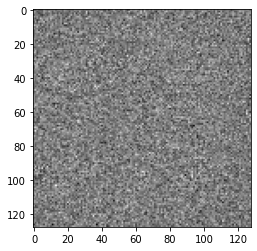

In [98]:
plot_img(inputs)

### autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2)
        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2)
        self.conv_3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2)
        self.conv_4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        
        # decoder
        self.deconv_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2)
        self.deconv_2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2)
        self.deconv_3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2)
        self.deconv_4 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2)
        self.deconv_5 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2)

    def forward(self, x):
        x = self._encode(x)
        x = self._decode(x)
        return x
    
    def _encode(self, x):
        x = torch.relu(self.conv_1(x))
        x = torch.relu(self.conv_2(x))
        x = torch.relu(self.conv_3(x))
        x = torch.relu(self.conv_4(x))
        x = torch.relu(self.conv_5(x))
        return x
    
    def _decode(self, x):
        x = torch.relu(self.deconv_1(x))
        x = torch.relu(self.deconv_2(x))
        x = torch.relu(self.deconv_3(x))
        x = torch.relu(self.deconv_4(x))
        x = torch.relu(self.deconv_5(x))
        x = F.pad(x, (0, 1, 0, 1))
        return x

In [ ]:
autoencoder = Autoencoder().to(device)

In [ ]:
sum(p.numel() for p in autoencoder.parameters())

In [ ]:
inputs = next(iter(train_loader))[0]
outputs = autoencoder(inputs)

inputs.shape, outputs.shape

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# train loop on epoch
def train(model, dataloader, criterion, optimizer):  #, device=device):
    
    avg_loss = 0  # calculate average loss
    avg_accuracy = 0  # calculate average accuracy
    
    loss_list = []
    accuracy_list = []

    model.train()  # use model for training (actual for dropout, batch normalization, etc.)
    for inputs, labels in (dataloader):  # iterate over training dataloader
#         inputs, labels = inputs.to(device), labels.to(device)  # transfer data to device

        # forward pass
        outputs = model(inputs).squeeze(-1)  # use model for prediction
        loss = criterion(outputs, inputs)  # compute loss using prediction and true labels

        # backward pass
        loss.backward()  # propagate model parameters gradients w.r.t loss
        optimizer.step()  # update parameters
        optimizer.zero_grad()  # zero gradients

#         # calculate batch accuracy
#         with torch.no_grad():  # disable gradient calculations for accuracy
#             pred = outputs > 0.5
#             accuracy = torch.sum(pred == labels)

        avg_loss += loss.item()
#         avg_accuracy += accuracy.item()
        
        loss_list.append(loss.item())
#         accuracy_list.append(accuracy.item() / BATCH_SIZE)

    # divide by the number of elements in dataset
    avg_loss /= len(dataloader.dataset)
#     avg_accuracy /= len(dataloader.dataset)

    return avg_loss, loss_list


# validation loop
def validate(model, dataloader, criterion):  #, device=device):
    
    avg_loss = 0  # calculate average loss
    avg_accuracy = 0  # calculate average accuracy
    
    loss_list = []
    accuracy_list = []

    model.eval()  # use model for testing (actual for dropout, batch normalization, etc.)
    for inputs, labels in (dataloader):
#         inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():  # disable gradient calculations
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, inputs)

#             # calculate batch accuracy
#             pred = outputs > 0.5
#             accuracy = torch.sum(pred == labels)

        avg_loss += loss.item()
#         avg_accuracy += accuracy.item()
        
        loss_list.append(loss.item())
#         accuracy_list.append(accuracy.item() / BATCH_SIZE)

    # divide by the number of elements in dataset
    avg_loss /= len(dataloader.dataset)
#     avg_accuracy /= len(dataloader.dataset)

    return avg_loss, loss_list

In [ ]:
# sanity check
val_loss, val_loss_list = validate(autoencoder, test_loader, criterion)
print(f'loss (test): {val_loss:.4f}')
# print(f'accuracy (test): {val_accuracy:.4f}\n')

In [ ]:
# train / validation loop
for epoch in range(N_EPOCHS):
    # train
    train_loss, train_loss_list = train(autoencoder, train_loader, criterion, optimizer)

    # validate
    val_loss, val_loss_list = validate(autoencoder, test_loader, criterion)

    # display
    print(f'epoch [{epoch+1}/{N_EPOCHS}]')
    print(f'loss (train/test): {train_loss:.4f}/{val_loss:.4f}')
#     print(f'accuracy (train/test): {train_accuracy:.4f}/{val_accuracy:.4f}\n')
    
#     plt.plot(train_loss_list)
    plt.plot(train_loss_list)
    plt.show()